# Data science

## Partie 1: Titanic

### Setup

In [314]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 9)

### Fonctions utilitaires

In [ ]:
def count_bins(arr1, arr2):
    '''Counts the number of bins on each dimensions for a 2d histogram'''
    return len(set(arr1)), len(set(arr2))

### Import des données depuis un fichier CSV

In [ ]:
titanic_data = np.genfromtxt('titanic.dat', delimiter=',', skip_header=1)

classes = titanic_data[:, 0]
ages = titanic_data[:, 1]
sexes = titanic_data[:, 2]
survived = titanic_data[:, 3]

### Nettoyage des données

#### Ages

Il y a deux valeurs possibles dans la variable age : 

In [ ]:
ages_values = list(set(ages))
ages_count_per_value = {v: sum(ages == v) for v in ages_values}
ages_count_per_value

Il parait probable que la première valeur, attribuée à 2092 personnes, désigne les adultes, tandis que l'autre valeur, attribuée à 109 personnes, désigne enfants, car il y a probablement plus d'adultes que d'enfants sur le bateau.

On peut binariser le tableau `ages` pour en faire un tableau `is_adult`, qui contient 1 si la personne est adulte et 0 si la personne est un enfant:

In [ ]:
is_adult = (ages < 0).astype(int)
is_adult

#### Sexes

Il y a deux valeurs possibles pour les sexes:

In [ ]:
sexes_values = list(set(sexes))
sexes_count_per_value = {v: sum(sexes == v) for v in sexes_values}
sexes_count_per_value

Il parait raisonnable de penser que sur un bateau de 1912, il y avait plus d'hommes que de femmes, soit 1731 hommes pour 470 femmes.

On peut binariser le tableau `sexes` en `is_male`:

In [ ]:
is_male = (sexes > 0).astype(int)
is_male

#### Classes

Il y a 4 valeurs possibles dans classes:

In [ ]:
classes_values = list(set(classes))
classes_count_per_value = {v: sum(classes== v) for v in classes_values}
classes_count_per_value


En se renseignant un peu sur le titanic, on peut apprendre qu'il y avait 3 classes sur le bâteau, plus l'équipage. Selon wikipédia, les effectifs sont les suivants:

- Première classe: 325 personnes
- Seconde classe: 285 personnes
- Troisième classe: 706 personnes
- Equipage: 908 personnes

Notre jeu de données ne semble pas contenir tout l'équipage, mais les autres chiffres correspondent. 

On peut simplifier les données en donnant des valeurs entières aux classes:

In [ ]:
def get_cleaned_class(c : int):
    if c > 0.1:
        return 0 # crew
    if c < -1:
        return 1 # first class
    if 0 > c > -1:
        return 2 # second class
    if 0 < c < 0.1:
        return 3 # third class


classes_clean = np.array([get_cleaned_class(c) for c in classes])
classes_clean

#### Survivants

Deux valeurs sont possibles pour les survivants:

In [ ]:
survived_values = set(survived)
survived_count_per_value = {v: sum(survived == v) for v in survived_values}
survived_count_per_value

Selon [wikipédia](https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic#/media/File:Titanic_casualties.svg), il y a 710 survivants et 1514 victimes. On peut conclure que la valeur -1 correspond aux victimes, tandis qu la valeur 1 correspond aux survivants.

On peut extraire une feature booléenne `is_survivor` de ces données:

In [ ]:
is_survivor = (survived == 1).astype(int)
is_survivor

### Class vs Age vs Sex

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig_3d = plt.figure()
ax = Axes3D(fig_3d)


points = list(zip(classes_clean, is_adult, is_male))
points_values = set(points)
points_counts = [points.count(point) for point in points_values]
points_survivors = [sum(is_survivor[i] 
                        for i, point in enumerate(points) 
                        if point == value)
                    for value in points_values]
points_survivors_rates = [point_survivors / float(points_counts[i]) 
                          for i, point_survivors in enumerate(points_survivors)]

x, y, z = zip(*points_values)

classes_ticks = [0, 1, 2, 3]
classes_ticklabels = ['crew', 'first class', 'second class', 'third class']

is_adult_ticks = [0, 1]
is_adult_ticklabels = ['child', 'adult']

is_male_ticks = [0, 1]
is_male_ticklabels = ['female', 'male']

ax.set_xlabel('class')
ax.set_xticks(classes_ticks)
ax.set_xticklabels(classes_ticklabels)

ax.set_ylabel('age')
ax.set_yticks(is_adult_ticks)
ax.set_yticklabels(is_adult_ticklabels)

ax.set_zlabel('sex')
ax.set_zticks(is_male_ticks)
ax.set_zticklabels(is_male_ticklabels)

ax.set_title('class vs age vs sex')
s = ax.scatter(x, y, z, sizes=points_counts, c=points_survivors_rates, alpha=1)
cbar = fig_3d.colorbar(s)
_ = cbar.ax.set_ylabel('survival rate')


On peut constater dans le graphique ci-dessus que les taux de survie les plus élevés sont chez les enfants de première et seconde classe, ainsi que chez les femmes de première classe. Ceux de troisième classe sont moins chanceux.

Les hommes adultes sont les plus nombreux, mais ils sont aussi ceux avec le taux de décès le plus nombreux. 

### Classe vs Age

Le graphique ci dessous affiche la nombre de personnes par classe et age. On peut constater qu'il y a plus d'adultes que d'enfants dans chaque classe, et que l'équipage ne comporte pas d'enfants.

In [ ]:
fig_class_age = plt.figure()
plt.xlabel('class')
plt.ylabel('age')
plt.title('class vs age')
_ = plt.hist2d(classes_clean, is_adult, norm=LogNorm(), bins=count_bins(classes_clean, ages))
_ = plt.xticks(classes_ticks, classes_ticklabels)
_ = plt.yticks(is_adult_ticks, is_adult_ticklabels)
cb = plt.colorbar()
_ = cb.ax.set_ylabel("number of persons")


### Classe vs Sexe

Le graphique ci-dessous montre le nombre de personnes par classe et par sexe. On peut constater que les hommes sont plus nombreux que les femmes dans toutes les classes, et en particulier dans l'équipage.


In [ ]:
fig_class_sex = plt.figure()
plt.xlabel('class')
plt.ylabel('sex')
plt.title('class vs sex')
_ = plt.hist2d(classes_clean, is_male, norm=LogNorm(), bins=count_bins(classes_clean, sexes))
_ = plt.xticks(classes_ticks, classes_ticklabels)
_ = plt.yticks(is_male_ticks, is_male_ticklabels)
cb = plt.colorbar()
_ = cb.ax.set_ylabel("number of persons")

### Age vs Sexe

Le graphique ci-dessous montre le nombre de personnes par age et par sexe. On peut constater que les adultes sont bien plus nombreux que les enfants. On peut aussi voir qu'il y a légérement plus de filles que de garçons chez les enfants.

In [ ]:
plt.xlabel('age')
plt.ylabel('sex')
plt.title('age vs sex')
_ = plt.hist2d(is_adult, is_male, norm=LogNorm(), bins=count_bins(ages, sexes))
_ = plt.xticks(is_adult_ticks, is_adult_ticklabels)
_ = plt.yticks(is_male, is_male_ticklabels)
cb = plt.colorbar()
_ = cb.ax.set_ylabel("number of persons")

### Recherche de K optimal

Le code suivant classifie les personnes du bateau en $k$ groupes à l'aide de la méthode des _K-means_, pour $k$ variant de 1 à 50.

La distance moyenne entre le barycentre de chaque groupe et ses membres est calculée pour chaque valeur de $k$, afin de pouvoir déterminer quel est le nombre de groupes optimal.

In [ ]:
from scipy.spatial import distance
from sklearn.cluster import KMeans

data = np.array(list(zip(
    is_adult, 
    is_male, 
    classes_clean)))

K = list(range(1, 50))
mean_dists = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    
    dists = []
    for i, label in enumerate(kmeans.labels_):
        row = data[i]
        cluster_center = kmeans.cluster_centers_[label]
        dist = distance.euclidean(row, cluster_center)
        dists.append(dist)
    
    mean_dist = np.mean(dists)
    mean_dists.append(mean_dist)

Le graphique suivant montre les distances calculées ci-dessus pour chaque valeur de $k$. La distance moyenne semble se stabiliser à partir de $k=13$.

In [ ]:
_ = plt.bar(K, mean_dists, )

_ = plt.xlabel("k")
_ = plt.ylabel("mean distance")

Pour plus de précision, le graphique ci-dessous affiche les mêmes données, mais avec une échele logarithmique pour les distances.

On se rend compte que la distance moyenne se stabilise vraiment à partir de $k=34$.

In [ ]:
_ = plt.bar(K, mean_dists, log=True)
_ = plt.xlabel("k")
_ = plt.ylabel("mean distance")


In [ ]:
kmeans = KMeans(n_clusters=34, random_state=0)
kmeans.fit(data)

fig_3d = plt.figure()
ax = Axes3D(fig_3d)

clusters_centers = kmeans.cluster_centers_
labels = kmeans.labels_

ax.set_xlabel('class')
ax.set_xticks(classes_ticks)
ax.set_xticklabels(classes_ticklabels)

ax.set_ylabel('age')
ax.set_yticks(is_adult_ticks)
ax.set_yticklabels(is_adult_ticklabels)

ax.set_zlabel('sex')
ax.set_zticks(is_male_ticks)
ax.set_zticklabels(is_male_ticklabels)

for cluster, cluster_center in enumerate(clusters_centers, 1):
    color = "C" + str(cluster % 10)
    
    cluster_is_adult = cluster_center[0]
    cluster_is_male = cluster_center[1]
    cluster_classes = cluster_center[2]
    
    ax.scatter(cluster_is_adult, cluster_is_male, cluster_classes, marker='x', color=color)

    row = [(classes[i], is_adult[i], is_male[i])
           for i, label in enumerate(labels)
           if label == cluster]
    if len(row) > 0:
        x, y, z = zip(*row)
        ax.scatter(x, y, z, color=color)


## Partie 2

### Chargements des datasets breast_cancer et wine

In [269]:
from sklearn import datasets

breast_cancer = datasets.load_breast_cancer()
wine = datasets.load_wine()

### Normalization of data

In [ ]:
from sklearn import preprocessing



### Learning

In [270]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

breast_cancer_kneighbors = KNeighborsClassifier().fit(breast_cancer['data'], breast_cancer['target'])
breast_cancer_decisiontree = DecisionTreeClassifier().fit(breast_cancer['data'], breast_cancer['target'])
breast_cancer_MLPC = MLPClassifier().fit(breast_cancer['data'], breast_cancer['target'])

wine_kneighbors = KNeighborsClassifier().fit(wine['data'], wine['target'])
wine_decisiontree = DecisionTreeClassifier().fit(wine['data'], wine['target'])
wine_MLPC = MLPClassifier().fit(wine['data'], wine['target'])


### Validation croisée à 5 segments

In [296]:

from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

kneighbors_classifiers = {'KNeighborsClassifier(%s)' % i: 
                              KNeighborsClassifier(i) 
                          for i in range(1, 100)}

decisiontree_classifiers = {'DecisionTreeClassifier(min_samples_leaf=%s)' % i: 
                                DecisionTreeClassifier(min_samples_leaf=i)
                            for i in range(1, 100)}

mlpc_classifiers = {
    'MLPClassifier(hidden_layer_sizes=(%s,%s), activation=%s, early_stopping=True)'
        % (l1, l2, activation): 
            MLPClassifier(hidden_layer_sizes=(l1,l2) if l2 > 0 else (l1,), 
                          activation=activation, 
                          early_stopping=True)
    for l1 in {20, 50, 100, 200}
    for l2 in {0, 20, 50, 100, 200}
    for activation in {'identity', 'logistic', 'tanh', 'relu'}
}

classifiers = dict()
classifiers.update(kneighbors_classifiers)
classifiers.update(decisiontree_classifiers)
classifiers.update(mlpc_classifiers)

datasets = {
    'breast_cancer': (breast_cancer['data'], breast_cancer['target']),
    'wine': (wine['data'], wine['target'])
}

rkf = RepeatedKFold(n_splits=5, n_repeats=10)

scores = {}
for dataset_name, dataset in datasets.items():
    data, target = dataset
    data = StandardScaler().fit_transform(data)
    
    for classifier_name, classifier in classifiers.items():
        score = cross_val_score(classifier, breast_cancer['data'], breast_cancer['target'], cv=rkf)
        key = "%s-%s" % (dataset_name, classifier_name)
        scores[key] = score

mean_scores = {key: np.mean(values) for key, values in scores.items()}

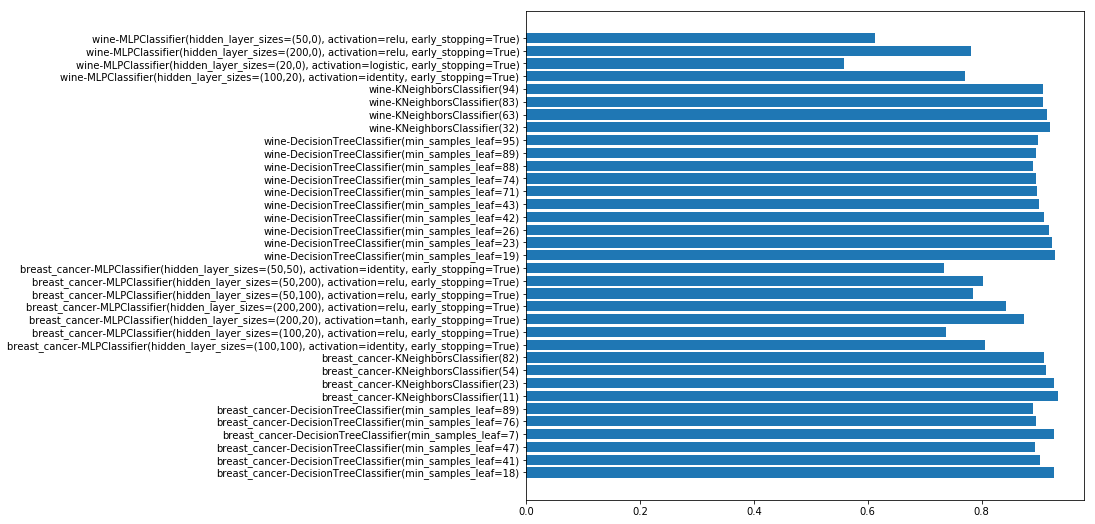

In [327]:
from collections import OrderedDict

best_mean_scores = {key: mean_scores[key] 
                    for key in sorted(mean_scores, key=lambda k: mean_scores[k], reverse=True)}
limit = 35
_  = plt.barh(list(best_mean_scores.keys())[:limit], list(best_mean_scores.values())[:limit])



## Partie 3

In [ ]:
# data from https://archive.ics.uci.edu/ml/datasets/online+news+popularity
news_data = np.genfromtxt('onlineNewsPopularity.csv', delimiter=',', skip_header=1)
nb_columns = np.shape(news_data)[1]
(
    url, # URL of the article (non-predictive)
    timedelta, # Days between the article publication and the dataset acquisition (non-predictive)
    n_tokens_title, # Number of words in the title
    n_tokens_content, # Number of words in the content
    n_unique_tokens, # Rate of unique words in the content
    n_non_stop_words, # Rate of non-stop words in the content
    n_non_stop_unique_tokens, # Rate of unique non-stop words in the content
    num_hrefs, # Number of links
    num_self_hrefs, # Number of links to other articles published by Mashable
    num_imgs, # Number of images
    num_videos, # Number of videos
    average_token_length, # Average length of the words in the content
    num_keywords, # Number of keywords in the metadata
    data_channel_is_lifestyle, # Is data channel 'Lifestyle'?
    data_channel_is_entertainment, # Is data channel 'Entertainment'?
    data_channel_is_bus, # Is data channel 'Business'?
    data_channel_is_socmed, # Is data channel 'Social Media'?
    data_channel_is_tech, # Is data channel 'Tech'?
    data_channel_is_world, # Is data channel 'World'?
    kw_min_min, # Worst keyword (min. shares)
    kw_max_min, # Worst keyword (max. shares)
    kw_avg_min, # Worst keyword (avg. shares)
    kw_min_max, # Best keyword (min. shares)
    kw_max_max, # Best keyword (max. shares)
    kw_avg_max, # Best keyword (avg. shares)
    kw_min_avg, # Avg. keyword (min. shares)
    kw_max_avg, # Avg. keyword (max. shares)
    kw_avg_avg, # Avg. keyword (avg. shares)
    self_reference_min_shares, # Min. shares of referenced articles in Mashable
    self_reference_max_shares, # Max. shares of referenced articles in Mashable
    self_reference_avg_sharess, # Avg. shares of referenced articles in Mashable
    weekday_is_monday, # Was the article published on a Monday?
    weekday_is_tuesday, # Was the article published on a Tuesday?
    weekday_is_wednesday, # Was the article published on a Wednesday?
    weekday_is_thursday, # Was the article published on a Thursday?
    weekday_is_friday, # Was the article published on a Friday?
    weekday_is_saturday, # Was the article published on a Saturday?
    weekday_is_sunday, # Was the article published on a Sunday?
    is_weekend, # Was the article published on the weekend?
    LDA_00, # Closeness to LDA topic 0
    LDA_01, # Closeness to LDA topic 1
    LDA_02, # Closeness to LDA topic 2
    LDA_03, # Closeness to LDA topic 3
    LDA_04, # Closeness to LDA topic 4
    global_subjectivity, # Text subjectivity
    global_sentiment_polarity, # Text sentiment polarity
    global_rate_positive_words, # Rate of positive words in the content
    global_rate_negative_words, # Rate of negative words in the content
    rate_positive_words, # Rate of positive words among non-neutral tokens
    rate_negative_words, # Rate of negative words among non-neutral tokens
    avg_positive_polarity, # Avg. polarity of positive words
    min_positive_polarity, # Min. polarity of positive words
    max_positive_polarity, # Max. polarity of positive words
    avg_negative_polarity, # Avg. polarity of negative words
    min_negative_polarity, # Min. polarity of negative words
    max_negative_polarity, # Max. polarity of negative words
    title_subjectivity, # Title subjectivity
    title_sentiment_polarity, # Title polarity
    abs_title_subjectivity, # Absolute subjectivity level
    abs_title_sentiment_polarity, # Absolute polarity level
    shares, # Number of shares (target)
) = (news_data[:, i] for i in range(nb_columns))